In [1]:
import tensorflow as tf
import numpy as np
import os
import re
from fuzzywuzzy import fuzz
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
from pyemd import emd
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
data_path = "/Users/Rutherford/Desktop/data"
epsilon = 1e-4

binary_file = os.path.join(data_path,
                           'GoogleNews-vectors-negative300.bin')
w2v_dat = os.path.join(data_path,'embed.dat')
w2v_vocab = os.path.join(data_path,'embed.vocab')

# create word embeddings and mapping of vocabulary item to index
embeddings = np.memmap(w2v_dat, dtype=np.float64,
                            mode="r", shape=(3000000, 300))
with open(w2v_vocab) as f:
    vocab_list = map(lambda string: string.strip(), f.readlines())
vocab_dict = {w: i for i, w in enumerate(vocab_list)}

# mean of 20 rarest words, used as a stand-in for pairwise distances
# if a word is out-of-vocabulary
avg_rare_word = np.mean(np.vstack(embeddings[-20:]),axis=0)
bad_row = np.asarray([avg_rare_word])


In [2]:
import pandas as pd

In [3]:
def cos_getter(strings):
    s_1 = strings['one']
    s_2 = strings['two']
    
    s_1 = re.sub(r'-',' ',s_1)
    s_1 = re.sub(r"\ba\b",'one',s_1)

    #s_2 = re.sub(r"\bs\d{0,2}\b",'speaker',s_2)
    #s_2 = re.sub(r"\b\d{5,6}\b",'timestamp',s_2)
    #s_2 = re.sub(r'\d+','digit',s_2)
    s_2 = re.sub(r'-',' ',s_2)
    s_2 = re.sub(r"\ba\b",'one',s_2)

    
    s1_features = s_1.split()
    s2_features = s_2.split()

    # sum of indices; proxy for word rarity
    ###results_.append(self._index_check(s1_features))
    ###results_.append(self._index_check(s2_features))        


    # number of out-of-vocabulary and in-vocabulary items
    #s_1_bad = sum(map(lambda word:word not in self.vocab_dict,s1_features))
    #s_1_good = sum(map(lambda word:word in self.vocab_dict,s1_features))
    #s_2_bad = sum(map(lambda word:word not in self.vocab_dict,s2_features))
    #s_2_good = sum(map(lambda word:word in self.vocab_dict,s2_features))
    ###results_.append(s_1_bad)
    ###results_.append(s_1_good)
    ###results_.append(s_2_bad)
    ###results_.append(s_2_good)

    # mean of word embeddings per string (0s if no items are in embeddings)
    # shape is [1,300] per string
    S1_ = embeddings[[vocab_dict[w] for w in s1_features if w in vocab_dict]]
    S2_ = embeddings[[vocab_dict[w] for w in s2_features if w in vocab_dict]]
    if S1_.shape[0]==0:
        S1_ = np.zeros((1,300))+epsilon
    if S2_.shape[0]==0:
        S2_ = np.zeros((1,300))+epsilon
    S1_ = np.asarray(np.mean(S1_,axis=0)).reshape([-1,1])
    S2_ = np.asarray(np.mean(S2_,axis=0)).reshape([-1,1])
    #results_.extend(S1_)
    #results_.extend(S2_)
    return cosine(S1_,S2_)


In [4]:
def WMD_cosine(strings):
    """Return counts of in-vocabulary and out-of-vocabulary items per
    string, means of embeddings per string, and Word Mover's Distance
    between the two. Word embeddings and mappings were created upon
    initialization of the class instance, and WMD with emd()
    (Earth Mover's Distance) from PyEMD. Final shape is [1,612].
    """
    
    s_1 = strings['one']
    s_2 = strings['two']

    #results_ = []

    ###############
    #s_1 = re.sub(r"\bs\d{0,2}\b",'speaker',s_1)
    #s_1 = re.sub(r"\b\d{5,6}\b",'timestamp',s_1)
    #s_1 = re.sub(r'\d+','digit',s_1)
    s_1 = re.sub(r'-',' ',s_1)
    s_1 = re.sub(r"\ba\b",'one',s_1)

    #s_2 = re.sub(r"\bs\d{0,2}\b",'speaker',s_2)
    #s_2 = re.sub(r"\b\d{5,6}\b",'timestamp',s_2)
    #s_2 = re.sub(r'\d+','digit',s_2)
    s_2 = re.sub(r'-',' ',s_2)
    s_2 = re.sub(r"\ba\b",'one',s_2)


    # moved this up here from mean of word embeddings section
    s1_features = s_1.split()
    s2_features = s_2.split()
    
    try:
        # fit CV on words with or without a single quote
        vect = CountVectorizer(token_pattern='[\w\']+').fit([s_1, s_2])
        features = np.asarray(vect.get_feature_names())
    except:
        return -1

    # get 'flow' vectors
    v_1, v_2 = vect.transform([s_1, s_2])
    v_1 = v_1.toarray().ravel().astype(np.float64)
    v_2 = v_2.toarray().ravel().astype(np.float64)

    # normalize vectors so as not to reward shorter strings in WMD
    v_1 /= (v_1.sum()+epsilon)
    v_2 /= (v_2.sum()+epsilon)

    # for each out-of-vocabulary item, use the average of the 20
    # rarest words' embeddings to represent it in the distance calc       
    W_ = np.ndarray([0,300])

    # get distance matrix for words in both strings
    for w in features:
        if w in vocab_dict:
            W_ = np.append(W_,embeddings[[vocab_dict[w]]],axis=0)
        else:
            W_ = np.append(W_,bad_row,axis=0)

    # use both euclidean and cosine dists (cosine dist is 1-cosine sim)
    #D_euclidean = euclidean_distances(W_).astype(np.float64)
    D_cosine = 1.-cosine_similarity(W_,).astype(np.float64)

    # using EMD (Earth Mover's Distance) from PyEMD
    #distances_euclidean = emd(v_1,v_2,D_euclidean)
    distances_cosine = emd(v_1,v_2,D_cosine)

    # both WMD calculations (euclidean and cosine)
    #results_.append(distances_euclidean)
    #results_.append(distances_cosine)

    return distances_cosine


In [5]:
def in_vocab(strings):

    s_1 = strings
    s1_features = s_1.split()

    # sum of indices; proxy for word rarity
    ###results_.append(self._index_check(s1_features))
    ###results_.append(self._index_check(s2_features))

    #s_1_bad = sum(map(lambda word:word not in self.vocab_dict,s1_features))
    s_1_good = sum(map(lambda word:word in vocab_dict,s1_features))
    
    return s_1_good

In [6]:
def out_of_vocab(strings):

    s_1 = strings
    s1_features = s_1.split()

    # sum of indices; proxy for word rarity
    ###results_.append(self._index_check(s1_features))
    ###results_.append(self._index_check(s2_features))

    s_1_bad = sum(map(lambda word:word not in vocab_dict,s1_features))
    #s_1_good = sum(map(lambda word:word in vocab_dict,s1_features))
    
    return s_1_bad
    

In [7]:
def euc_getter(strings):
    s_1 = strings['one']
    s_2 = strings['two']
    
    s_1 = re.sub(r'-',' ',s_1)
    s_1 = re.sub(r"\ba\b",'one',s_1)

    #s_2 = re.sub(r"\bs\d{0,2}\b",'speaker',s_2)
    #s_2 = re.sub(r"\b\d{5,6}\b",'timestamp',s_2)
    #s_2 = re.sub(r'\d+','digit',s_2)
    s_2 = re.sub(r'-',' ',s_2)
    s_2 = re.sub(r"\ba\b",'one',s_2)

    
    s1_features = s_1.split()
    s2_features = s_2.split()

    # sum of indices; proxy for word rarity
    ###results_.append(self._index_check(s1_features))
    ###results_.append(self._index_check(s2_features))        


    # number of out-of-vocabulary and in-vocabulary items
    #s_1_bad = sum(map(lambda word:word not in self.vocab_dict,s1_features))
    #s_1_good = sum(map(lambda word:word in self.vocab_dict,s1_features))
    #s_2_bad = sum(map(lambda word:word not in self.vocab_dict,s2_features))
    #s_2_good = sum(map(lambda word:word in self.vocab_dict,s2_features))
    ###results_.append(s_1_bad)
    ###results_.append(s_1_good)
    ###results_.append(s_2_bad)
    ###results_.append(s_2_good)

    # mean of word embeddings per string (0s if no items are in embeddings)
    # shape is [1,300] per string
    S1_ = embeddings[[vocab_dict[w] for w in s1_features if w in vocab_dict]]
    S2_ = embeddings[[vocab_dict[w] for w in s2_features if w in vocab_dict]]
    if S1_.shape[0]==0:
        S1_ = np.zeros((1,300))+epsilon
    if S2_.shape[0]==0:
        S2_ = np.zeros((1,300))+epsilon
    S1_ = np.asarray(np.mean(S1_,axis=0)).reshape([-1,1])
    S2_ = np.asarray(np.mean(S2_,axis=0)).reshape([-1,1])
    #results_.extend(S1_)
    #results_.extend(S2_)
    return euclidean(S1_,S2_)


In [8]:
from scipy.spatial.distance import euclidean

In [9]:
training_set = '/Users/Rutherford/Desktop/data/dataset.csv'
#training_set = '/Users/Rutherford/Desktop/data/cleaned 10:27/dataset.csv'

In [10]:
df = pd.read_csv(training_set,header=None,dtype={'error':np.int32,'one':str,'two':str},na_filter=False)
df.columns = ['error','one','two']
# map all ___ to ''
# if len(two) is zero, indicate that with a binary feature. maybe don't use lengths at all?
df.replace(r'\_{2,}','',regex=True,inplace=True)

In [13]:
df['cosine'] = df.apply(cos_getter,axis=1)
df['len1'] = map(len,df['one'].values)
df['len2'] = map(len,df['two'].values)
df['wmd_cos'] = df[['one','two']].apply(WMD_cosine,axis=1)
df['error'].loc[df['len2']==0] = 1
df['s1_good'] = df['one'].apply(in_vocab)
df['s2_good'] = df['two'].apply(in_vocab)
df['s1_bad'] = df['one'].apply(out_of_vocab)
df['s2_bad'] = df['two'].apply(out_of_vocab)
df['euclidean'] = df[['one','two']].apply(euc_getter,axis=1)

/Users/Rutherford/anaconda2/envs/tensorflow/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
df.head()

,error,one,two,cosine,len1,len2,wmd_cos,s1_good,s2_good,s1_bad,s2_bad,euclidean
0,2,zero,four zero,0.148332,4,9,0.410142,1,2,0,0,1.513861
1,2,youth,year,0.852059,5,4,0.851974,1,1,0,0,2.970946
2,2,yourselves,ourselves,0.345502,10,9,0.345468,1,1,0,0,2.694515
3,2,your,rent,0.890149,4,4,0.890060,1,1,0,0,3.908750
4,2,your,new,0.820352,4,3,0.820270,1,1,0,0,3.100446


In [15]:
df['wmd_norm'] = df['wmd_cos']-df['wmd_cos'].mean()
df['cos_norm'] = df['cosine']-df['cosine'].mean()
df['euc_norm'] = df['euclidean']-df['euclidean'].mean()

In [16]:
df.head()

,error,one,two,cosine,len1,len2,wmd_cos,s1_good,s2_good,s1_bad,s2_bad,euclidean,wmd_norm,cos_norm,euc_norm
0,2,zero,four zero,0.148332,4,9,0.410142,1,2,0,0,1.513861,-0.091989,-0.300641,-0.080676
1,2,youth,year,0.852059,5,4,0.851974,1,1,0,0,2.970946,0.349842,0.403086,1.376409
2,2,yourselves,ourselves,0.345502,10,9,0.345468,1,1,0,0,2.694515,-0.156664,-0.103470,1.099978
3,2,your,rent,0.890149,4,4,0.890060,1,1,0,0,3.908750,0.387929,0.441177,2.314213
4,2,your,new,0.820352,4,3,0.820270,1,1,0,0,3.100446,0.318139,0.371380,1.505909


In [17]:
g1, g2 = df.groupby('error')

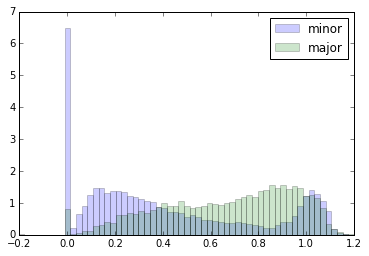

In [18]:
bins = np.linspace(-.2, 1.2, 60)
plt.hist(g1[1]['cosine'],bins,alpha=.2,label='minor',normed=True)
plt.hist(g2[1]['cosine'],bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

In [19]:
vocab_dict["'cause"]

KeyError: "'cause"

In [20]:
g1[1].iloc[(g1[1]['cosine']>.8).values]#&(g1[1]['cosine']<1.))

,error,one,two,cosine,len1,len2,wmd_cos,s1_good,s2_good,s1_bad,s2_bad,euclidean,wmd_norm,cos_norm,euc_norm
21,1,you,,1.083966,3,0,-2.220224e-16,1,0,0,0,2.326611,-0.502131,0.634994,0.732074
195,1,x,,0.996228,1,0,-2.220224e-16,1,0,0,0,2.708646,-0.502131,0.547255,1.114109
892,1,trying to,,0.944429,9,0,9.383879e-01,1,0,1,0,2.586670,0.436257,0.495456,0.992133
1269,1,themselves,,1.044751,10,0,2.220224e-16,1,0,0,0,2.523279,-0.502131,0.595779,0.928742
1457,1,tat,,0.979348,3,0,1.110112e-16,1,0,0,0,2.994201,-0.502131,0.530375,1.399664
1554,1,suffer,,1.070992,6,0,1.110112e-16,1,0,0,0,2.884658,-0.502131,0.622019,1.290121
1617,1,stories,,0.935720,7,0,1.110112e-16,1,0,0,0,2.873144,-0.502131,0.486748,1.278607
1667,1,statute,,0.956447,7,0,1.110112e-16,1,0,0,0,3.586507,-0.502131,0.507475,1.991970
1845,1,sorry the echo chuckle is distracting me a lit...,,0.958926,53,0,1.034731e+00,9,0,1,0,1.242916,0.532600,0.509954,-0.351621
2068,1,sign,,0.983389,4,0,-2.220224e-16,1,0,0,0,2.545611,-0.502131,0.534416,0.951075


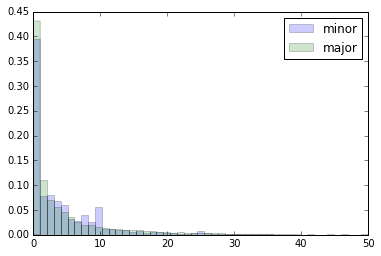

In [21]:
fig = plt.figure()
bins = np.linspace(0, 50, 50)
plt.hist(g1[1]['len2']-g1[1]['len1'],bins,alpha=.2,label='minor',normed=True)
plt.hist(g2[1]['len2']-g2[1]['len1'],bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

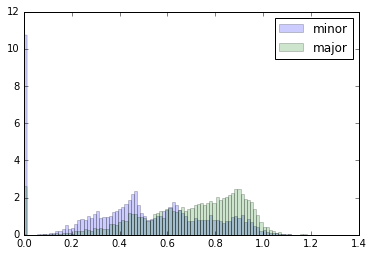

In [22]:
bins = np.linspace(0,1.3,100)
plt.hist(g1[1]['wmd_cos'],bins,alpha=.2,label='minor',normed=True)
plt.hist(g2[1]['wmd_cos'],bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

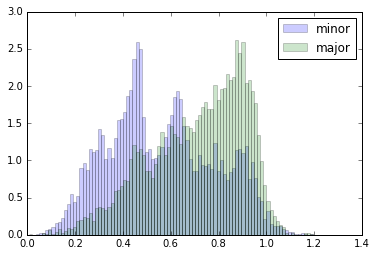

In [23]:
bins = np.linspace(0.01,1.3,100)
plt.hist(g1[1]['wmd_cos'],bins,alpha=.2,label='minor',normed=True)
plt.hist(g2[1]['wmd_cos'],bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

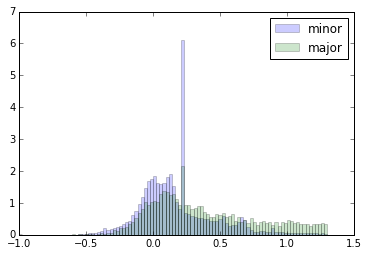

In [24]:
#added this tuesday
bins = np.linspace(-1,1.3,100)
plt.hist(g1[1]['wmd_norm']+(g1[1]['euc_norm']*g1[1]['cos_norm']),bins,alpha=.2,label='minor',normed=True)
plt.hist(g2[1]['wmd_norm']+(g2[1]['euc_norm']*g2[1]['cos_norm']),bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

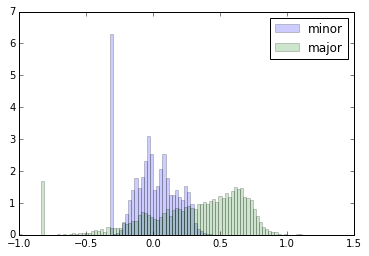

In [25]:
#added this tuesday
bins = np.linspace(-1,1.3,100)
plt.hist(g1[1]['wmd_norm']*g1[1]['cosine'].mean()*g1[1]['euclidean'].mean(),bins,alpha=.2,label='minor',normed=True)
plt.hist(g2[1]['wmd_norm']*g2[1]['cosine'].mean()*g2[1]['euclidean'].mean(),bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

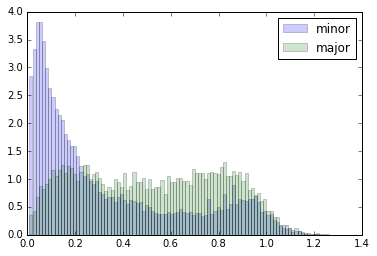

In [26]:
#this is a little interesting
bins = np.linspace(0.01,1.3,100)
plt.hist(g1[1]['wmd_cos']*g1[1]['cosine'],bins,alpha=.2,label='minor',normed=True)
plt.hist(g2[1]['wmd_cos']*g2[1]['cosine'],bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

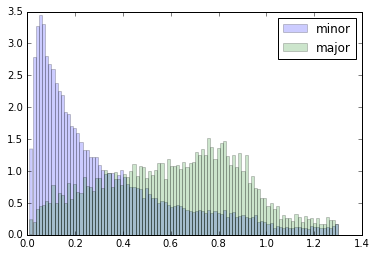

In [27]:
#plt.hist(g1[1]['wmd_cos']*((g1[1]['s2_bad']+g1[1]['s1_bad'])/(g1[1]['s2_good']+g1[1]['s1_good']+epsilon))*g1[1]['cosine'],bins,alpha=.2,label='minor',normed=True)
#plt.hist(g2[1]['wmd_cos']*((g2[1]['s2_bad']+g2[1]['s1_bad'])/(g2[1]['s2_good']+g2[1]['s1_good']+epsilon))*g2[1]['cosine'],bins,alpha=.2,label='major',normed=True)

bins = np.linspace(0.01,1.3,100)
plt.hist(g1[1]['cosine']*g1[1]['s2_good']*g1[1]['wmd_cos'],bins,alpha=.2,label='minor',normed=True)
plt.hist(g2[1]['cosine']*g2[1]['s2_good']*g2[1]['wmd_cos'],bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

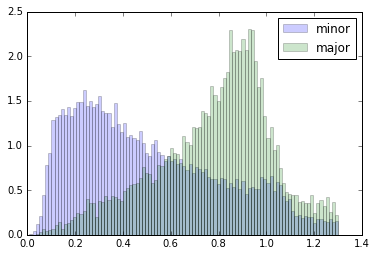

In [28]:
bins = np.linspace(0.01,1.3,100)
plt.hist(g1[1]['cosine']*g1[1]['s2_good'],bins,alpha=.2,label='minor',normed=True)
plt.hist(g2[1]['cosine']*g2[1]['s2_good'],bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

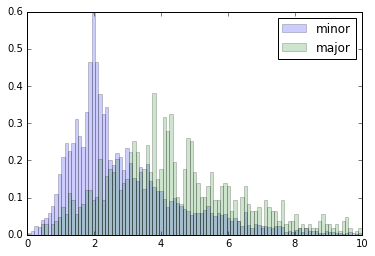

In [29]:
bins = np.linspace(0.01,10,100)
plt.hist((g1[1]['cosine']+g1[1]['euclidean'])*(g1[1]['s2_good']/(g1[1]['s1_bad']+epsilon)),bins,alpha=.2,label='minor',normed=True)
plt.hist((g2[1]['cosine']+g2[1]['euclidean'])*(g2[1]['s2_good']/(g2[1]['s1_bad']+epsilon)),bins,alpha=.2,label='major',normed=True)
plt.legend(loc='upper right')
plt.show()

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split

In [31]:
rf = RandomForestClassifier()

In [32]:
df.columns

Index([u'error', u'one', u'two', u'cosine', u'len1', u'len2', u'wmd_cos',
       u's1_good', u's2_good', u's1_bad', u's2_bad', u'euclidean', u'wmd_norm',
       u'cos_norm', u'euc_norm'],
      dtype='object')

In [ ]:
# things that didn't do much

#df['to_nothing'] = 0
#df['to_nothing'].ix[df.loc[df['len2']==0].index.values.tolist()]=1
#df.drop('to_nothing',axis=1,inplace=True)

#df2=df.loc[df['wmd_cos']!=0]

In [33]:
vocab_dict['wilshire']

KeyError: 'wilshire'

In [34]:
# what do these have in common?
# get rid of these and many FNs go away
g2[1].loc[g2[1]['wmd_cos']<.51]#.ix[7500:]

,error,one,two,cosine,len1,len2,wmd_cos,s1_good,s2_good,s1_bad,s2_bad,euclidean,wmd_norm,cos_norm,euc_norm
0,2,zero,four zero,1.483317e-01,4,9,4.101423e-01,1,2,0,0,1.513861,-0.091989,-0.300641,-0.080676
2,2,yourselves,ourselves,3.455021e-01,10,9,3.454675e-01,1,1,0,0,2.694515,-0.156664,-0.103470,1.099978
12,2,younger,youngest,5.072555e-01,7,8,5.072048e-01,1,1,0,0,2.838783,0.005074,0.058283,1.244246
13,2,young,younger,3.649059e-01,5,7,3.648694e-01,1,1,0,0,2.053551,-0.137262,-0.084067,0.459014
15,2,you,you virtually,3.018555e-01,3,13,4.789627e-01,1,2,0,0,1.669759,-0.023169,-0.147117,0.075222
17,2,you,us,4.847729e-01,3,2,4.847244e-01,1,1,0,0,2.220452,-0.017407,0.035800,0.625915
19,2,you,me,4.320175e-01,3,2,4.319743e-01,1,1,0,0,2.219418,-0.070157,-0.016955,0.624881
25,2,you've struggled,you struggle,4.573711e-01,16,12,4.672018e-01,2,2,0,0,1.784883,-0.034929,0.008399,0.190346
26,2,you've seen a,you see the,3.959219e-01,13,11,4.914075e-01,2,3,1,0,1.229981,-0.010724,-0.053051,-0.364556
32,2,you've games,these games,3.119531e-01,12,11,3.883243e-01,2,2,0,0,1.526488,-0.113807,-0.137019,-0.068049


In [35]:
# 'cause, 'bout, 'til
# blank to something
# short, related but opposite
# numbers that are different

In [36]:
vocab_dict["til"]

31231

In [37]:
g2[1].loc[g2[1]['len1']==0].shape

(625, 15)

In [40]:
g1[1].loc[g1[1]['len1']==0].shape

(2681, 15)

In [41]:
X = df[['cosine','euclidean','len1','len2','wmd_cos']]
y = df['error']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [43]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [44]:
rf.score(X_test,y_test)

0.89734736157939632